# Building Energy Consumption

The notebook explores the historical weather data from 2018 to 2021 as well as energy consumption data of a single building in Berkeley, California. It looks for correlations in weather features and which ones might help explain energy consumption. The dataset will be used for modeling in the next notebook.

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np

## Weather Data

Data Source: OpenWeather https://openweathermap.org/

In [38]:
file_name = 'HistoricalBerkeleyWeatherData.csv'
data_path = "C:/Users/Documents/Data_Science_Project/"

In [39]:
df = pd.read_csv(data_path + file_name)
print(df.shape)

(26328, 28)


In [40]:
# Describe full dataset
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,dt,timezone,lat,lon,temp,visibility,dew_point,feels_like,temp_min,temp_max,...,humidity,wind_speed,wind_deg,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id
count,26328.00,26328.00,26328.00,26328.00,26328.00,0.00,26328.00,26328.00,26328.00,26328.00,...,26328.00,26328.00,26328.00,9748.00,3157.00,0.00,0.00,0.00,26328.00,26328.00
mean,1562153400.00,-26457.29,37.87,-122.27,287.79,NaN,282.61,287.12,285.94,289.60,...,73.73,3.94,222.90,0.72,1.98,NaN,NaN,NaN,46.70,765.71
std,27361379.81,1716.27,0.00,0.00,4.64,NaN,4.22,5.05,3.86,5.24,...,17.30,2.12,83.94,1.97,5.48,NaN,NaN,NaN,40.79,97.95
min,1514764800.00,-28800.00,37.87,-122.27,275.59,NaN,257.69,270.93,273.98,277.72,...,6.00,0.00,0.00,0.00,0.10,NaN,NaN,NaN,0.00,500.00
25%,1538459100.00,-28800.00,37.87,-122.27,284.61,NaN,280.42,283.94,283.47,285.81,...,63.00,2.53,189.00,0.00,0.25,NaN,NaN,NaN,2.00,800.00
50%,1562153400.00,-25200.00,37.87,-122.27,287.19,NaN,283.42,286.73,285.92,288.52,...,78.00,3.60,230.00,0.00,0.38,NaN,NaN,NaN,40.00,801.00
75%,1585847700.00,-25200.00,37.87,-122.27,290.40,NaN,285.59,290.02,288.22,292.53,...,88.00,5.10,280.00,0.00,1.07,NaN,NaN,NaN,92.00,803.00
max,1609542000.00,-25200.00,37.87,-122.27,312.34,NaN,293.74,313.97,309.42,317.03,...,100.00,16.00,360.00,20.12,49.53,NaN,NaN,NaN,100.00,804.00


In [41]:
df.weather_main.unique(),df.weather_description.unique()

(array(['Clouds', 'Rain', 'Clear'], dtype=object),
 array(['scattered clouds', 'broken clouds', 'few clouds',
        'overcast clouds', 'light rain', 'moderate rain', 'sky is clear',
        'heavy intensity rain', 'very heavy rain'], dtype=object))

In [42]:
# Exmaine columns, data types, and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26328 entries, 0 to 26327
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   26328 non-null  int64  
 1   dt_iso               26328 non-null  object 
 2   timezone             26328 non-null  int64  
 3   city_name            26328 non-null  object 
 4   lat                  26328 non-null  float64
 5   lon                  26328 non-null  float64
 6   temp                 26328 non-null  float64
 7   visibility           0 non-null      float64
 8   dew_point            26328 non-null  float64
 9   feels_like           26328 non-null  float64
 10  temp_min             26328 non-null  float64
 11  temp_max             26328 non-null  float64
 12  pressure             26328 non-null  int64  
 13  sea_level            0 non-null      float64
 14  grnd_level           0 non-null      float64
 15  humidity             26328 non-null 

### Conversions

In [43]:
def kelvin_to_fahrenheit(kelvin_temp):
    """
    Convert temperature from Kelvin to Fahrenheit.
    Formula: F = (K - 273.15) * 9/5 + 32
    """
    fahrenheit_temp = (kelvin_temp - 273.15) * 9/5 + 32
    return fahrenheit_temp

In [44]:
# Convert temperature columns from Kelvin to Fahrenheit
kelvin_columns = ['temp','feels_like', 'temp_min', 'temp_max']

for column in kelvin_columns:
    if column in df.columns:
        df[column] = df[column].apply(kelvin_to_fahrenheit)
    else:
        print(f"Column '{column}' not found in DataFrame.")

In [45]:
def convert_meters_per_sec_to_mph(mps):
    """
    Convert wind speed from meters per second to miles per hour.
    Formula: MPH = 2.23694 * MPS
    """
    mph = round(2.23694 * mps, 2)
    return mph

# Convert meters per second to miles per hour
df['wind_speed'] = df['wind_speed'].apply(convert_meters_per_sec_to_mph)

In [46]:
# Convert column to datatime format for timeseries data
df['dt_iso'] = df['dt_iso'].str.replace(' +0000 UTC', '', regex=False)
df['dt_iso'] = pd.to_datetime(df['dt_iso'], format='%Y-%m-%d %H:%M:%S')
df.set_index('dt_iso', inplace=True)

In [47]:
# Resample to daily intervals
df_day = df.resample('D').mean()

# Resample to hourly intervals
df_hour = df.resample('H').mean()

### Plots

In [68]:
# Segment features for exploration
time = df.index
temperature = df['temp']
relative_humidity = df['humidity']
wind_speed = df['wind_speed']
pressure = df['pressure']
dew_point = df['dew_point']
wind_gust = df['wind_gust']

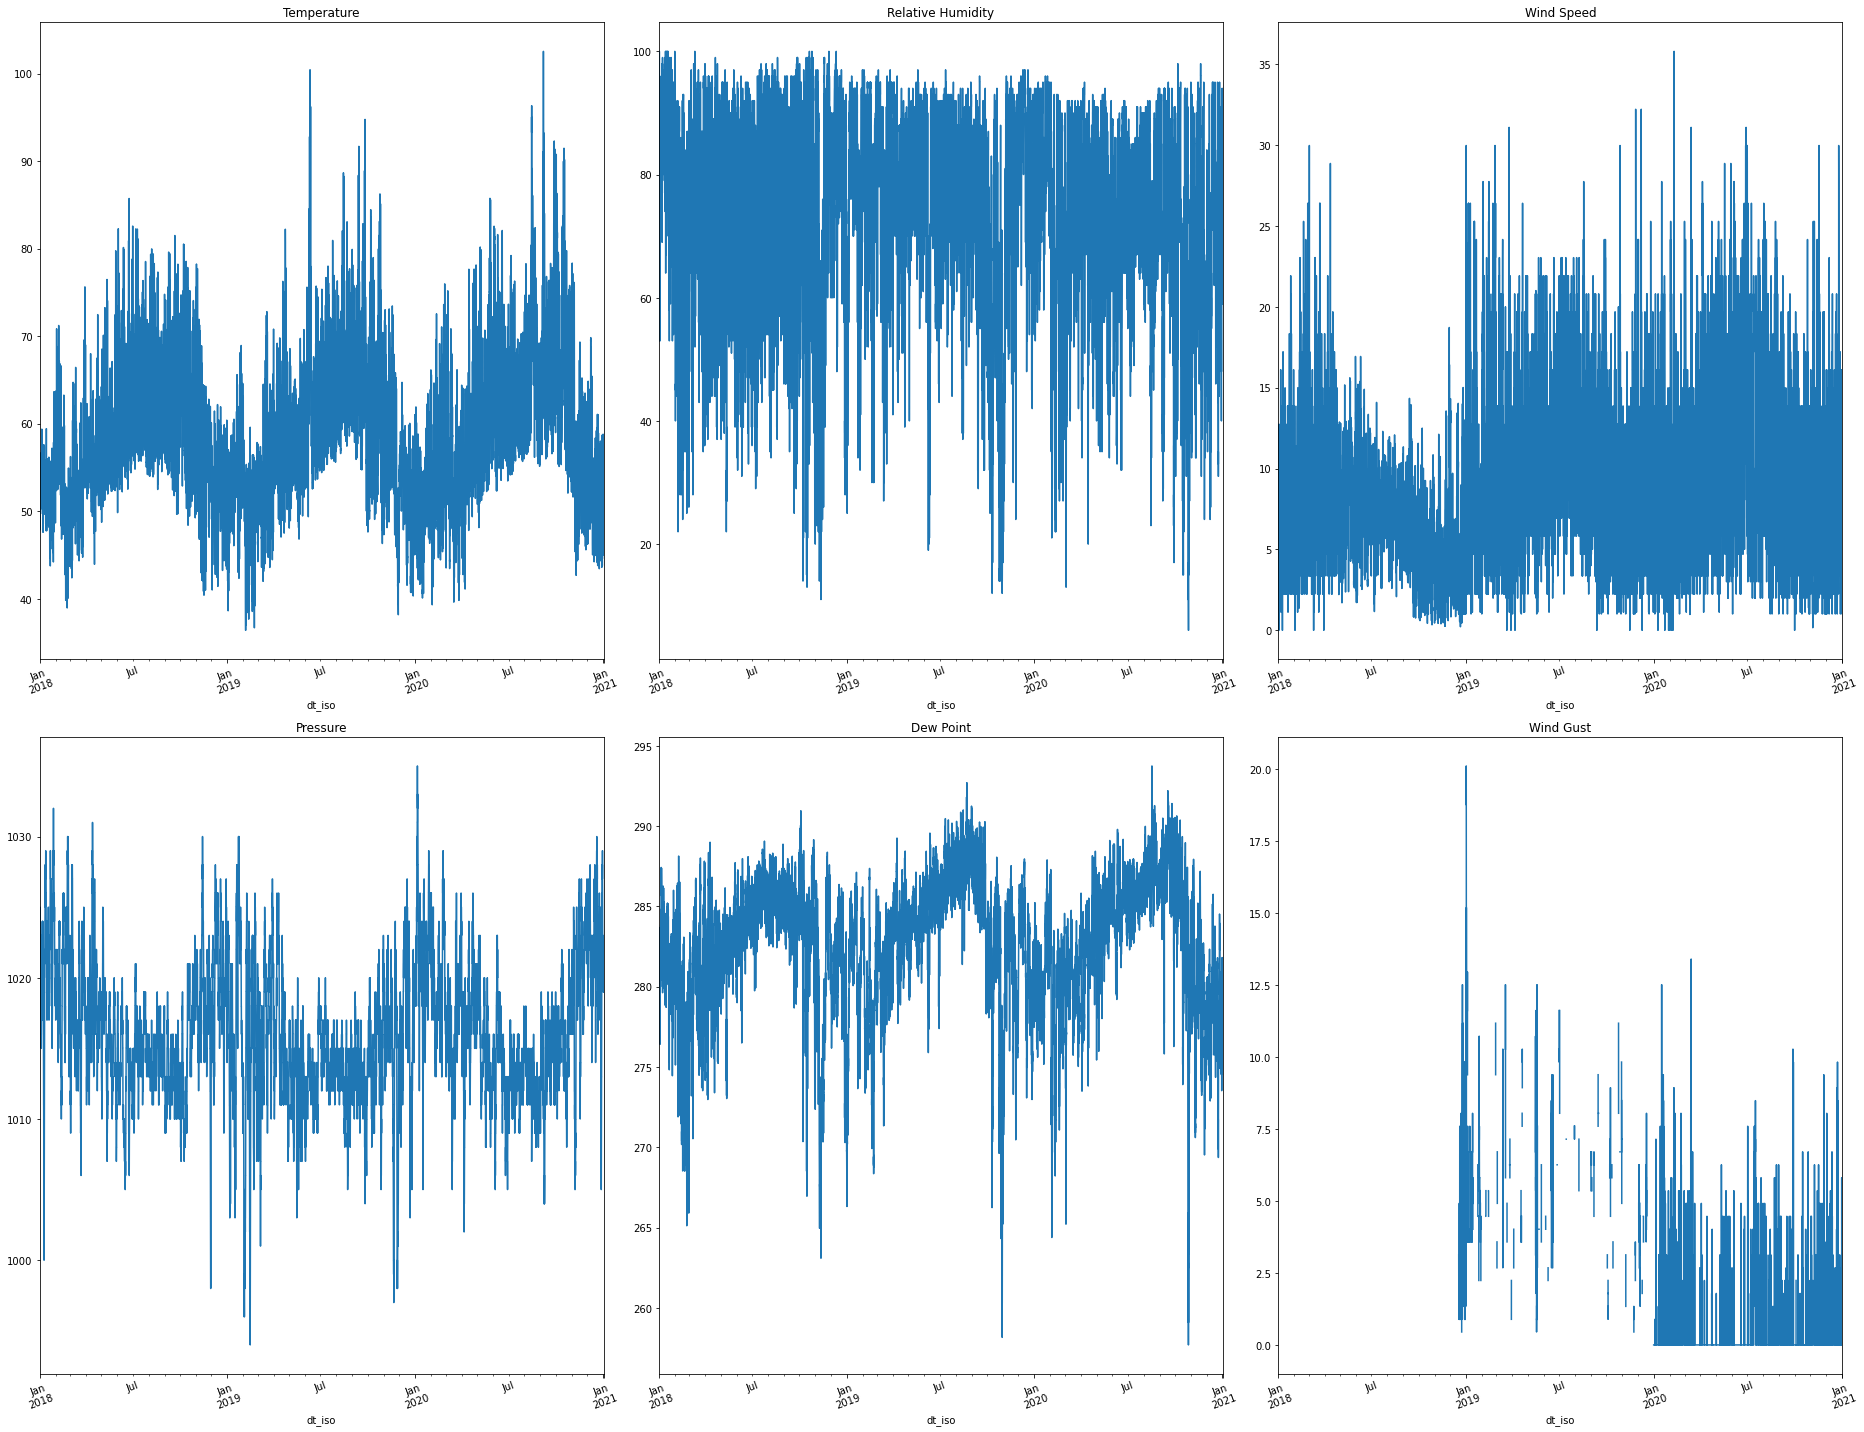

In [69]:
plt.subplots(nrows=2, ncols=3, figsize=(26, 20))

ax = plt.subplot(2, 3, 1)
temperature.index = time
temperature.head()
temperature.plot(rot=20)
plt.title('Temperature')

ax = plt.subplot(2, 3, 2)
relative_humidity.index = time
relative_humidity.head()
relative_humidity.plot(rot=20)
plt.title('Relative Humidity')

ax = plt.subplot(2, 3, 3)
wind_speed.index = time
wind_speed.head()
wind_speed.plot(rot=20)
plt.title('Wind Speed')

ax = plt.subplot(2, 3, 4)
pressure.index = time
pressure.head()
pressure.plot(rot=20)
plt.title('Pressure')

ax = plt.subplot(2, 3, 5)
dew_point.index = time
dew_point.head()
dew_point.plot(rot=20)
plt.title('Dew Point')

ax = plt.subplot(2, 3, 6)
wind_gust.index = time
wind_gust.head()
wind_gust.plot(rot=20)
plt.title('Wind Gust')

plt.tight_layout()
plt.show()

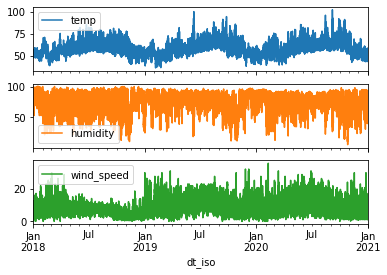

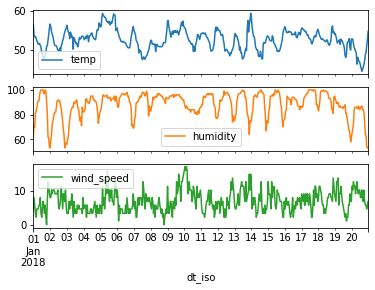

In [70]:
# Line plot for temperature, humidity, and wind speed over time - entire dataset
plot_cols = ['temp', 'humidity', 'wind_speed']
plot_features = df[plot_cols]
date_time = df.index
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

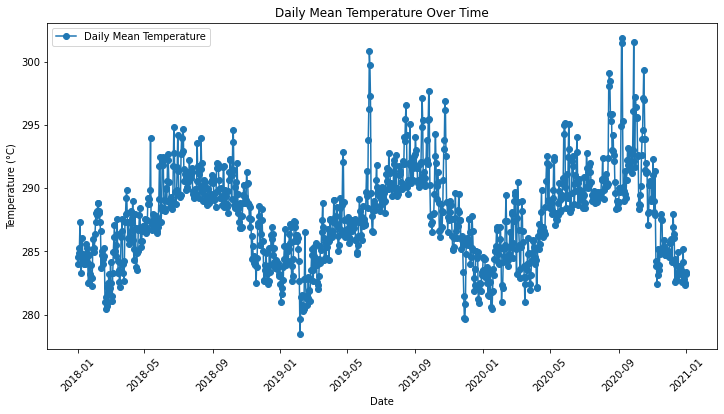

In [21]:
# Line plot for temperature over time by day
plt.figure(figsize=(12, 6))
plt.plot(df_day.index, df_day['temp'], label='Daily Mean Temperature', marker='o', linestyle='-')
plt.title('Daily Mean Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

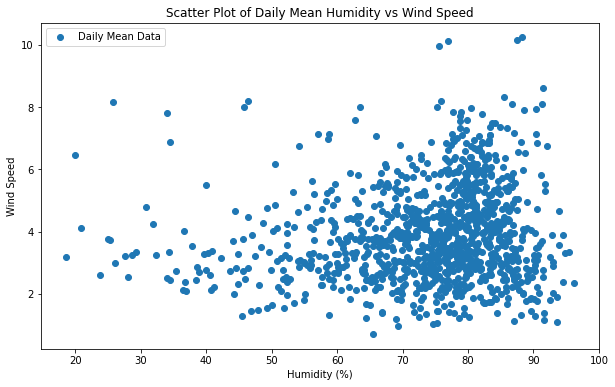

In [22]:
# Scatter plot for humidity and temperature
plt.figure(figsize=(10, 6))
plt.scatter(df_day['humidity'], df_day['wind_speed'], label='Daily Mean Data')
plt.title('Scatter Plot of Daily Mean Humidity vs Wind Speed')
plt.xlabel('Humidity (%)')
plt.ylabel('Wind Speed')
plt.legend()
plt.show()

### Features Selection

- Temperature ('temp'):
     - Temperature is a critical factor influencing heating and cooling requirements in buildings. Colder temperatures generally result in increased heating needs, while hotter temperatures increase the demand for cooling. Therefore, temperature is a key predictor for building energy consumption.

- Humidity ('humidity'):
     - Humidity affects the perception of temperature and influences the efficiency of heating and cooling systems. High humidity can make people feel warmer, affecting the cooling demand. Including humidity as a predictor helps capture the combined impact of temperature and humidity on energy consumption.

- Wind Speed ('wind_speed'):
     - Wind speed is relevant for buildings as it can affect heat loss or gain. Higher wind speeds may increase heat loss from buildings, impacting heating requirements. Wind speed is an important factor in understanding the overall thermal dynamics of a building and is thus included as a predictor.
     
- Dew Point ('dew_point'):
    - Dew point is the temperature at which air becomes saturated with moisture and dew forms. It provides insights into the moisture content in the air, influencing the perceived comfort and potential for condensation. Dew point is a valuable parameter for understanding the atmospheric conditions and their impact on building environments.

- Atmospheric Pressure ('pressure'):
    - Atmospheric pressure is the force exerted by the air above a given point in the Earth's atmosphere. It can influence weather patterns and building operations. Including atmospheric pressure as a predictor helps account for variations in pressure that may affect energy consumption and building performance.

### Subset Weather Features

In [61]:
# Select relevant columns and set 'dt_iso' as the index
df_hour_subset = df_hour[['temp','temp_min','temp_max','feels_like',
          'humidity','wind_speed','pressure','dew_point']]

# Display the first few rows of the subset DataFrame
print("First few rows of df_hour_subset:")
print(df_hour_subset.shape)
display(df_hour_subset.head())

First few rows of df_hour_subset:
(26328, 8)


,temp,temp_min,temp_max,feels_like,humidity,wind_speed,pressure,dew_point
dt_iso,,,,,,,,
2018-01-01 00:00:00,56.59,53.91,58.95,54.86,62.00,4.70,1019.00,279.67
2018-01-01 01:00:00,53.87,53.01,56.07,52.29,71.00,8.05,1019.00,280.21
2018-01-01 02:00:00,53.38,52.83,55.35,51.71,70.00,5.82,1020.00,279.74
2018-01-01 03:00:00,53.49,53.01,54.81,52.34,81.00,3.36,1020.00,281.94
2018-01-01 04:00:00,53.06,52.65,54.45,51.96,83.00,2.24,1020.00,282.06


### Building Energy Consumption

Data Source: https://www.nature.com/articles/s41597-022-01257-x#Sec13 from https://datadryad.org/stash/dataset/doi:10.7941/D1N33Q and code https://github.com/LBNL-ETA/Data-Cleaning/blob/main/Data%20cleaning_Bldg59.py

City: Berkeley, California

In [55]:
# Path to csv files
ele_path = data_path + '/building_consumption/ele.csv'
site_weather_path = data_path + '/building_consumption/site_weather.csv'

# Load CSV files into DataFrames
ele_data = pd.read_csv(ele_path)  
site_weather_data = pd.read_csv(site_weather_path) 

# Convert 'date' columns to datetime format
ele_data['date'] = pd.to_datetime(ele_data['date'], format='%Y/%m/%d %H:%M')
site_weather_data['date'] = pd.to_datetime(site_weather_data['date'], format='%Y-%m-%d %H:%M:%S')

# Display the first few rows of each DataFrame
print("First few rows of ele.csv:")
print(ele_data.shape)
# display(ele_data.head())

print("\nFirst few rows of site_weather.csv:")
print(site_weather_data.shape)
# site_weather_data.head()

First few rows of ele.csv:
(103048, 7)

First few rows of site_weather.csv:
(105217, 6)


In [56]:
# Merge the datasets on the 'date' column
merged_data = pd.merge(ele_data, site_weather_data, on='date', how='inner')
merged_data.drop(columns=['Unnamed: 6'],inplace=True)

# Display the first few rows of the merged DataFrame
print("First few rows of the merged DataFrame:")
print(merged_data.shape)
# display(merged_data.head())

First few rows of the merged DataFrame:
(101523, 11)


,date,mels_S,lig_S,mels_N,hvac_N,hvac_S,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
0,2018-01-01 01:00:00,1.20,0.20,7.50,37.40,19.50,11.12,11.15,8.04,81.50,6.45
1,2018-01-01 01:15:00,1.30,0.20,6.80,37.50,19.89,10.94,11.01,7.99,82.20,1.81
2,2018-01-01 01:30:00,1.10,0.20,7.40,38.00,19.30,10.79,10.84,7.93,82.70,0.24
3,2018-01-01 01:45:00,1.20,0.20,7.70,37.20,18.89,10.71,10.73,8.02,83.60,0.00
4,2018-01-01 02:00:00,1.10,0.20,7.30,37.40,24.70,10.79,10.84,8.01,83.10,0.00


### Plots

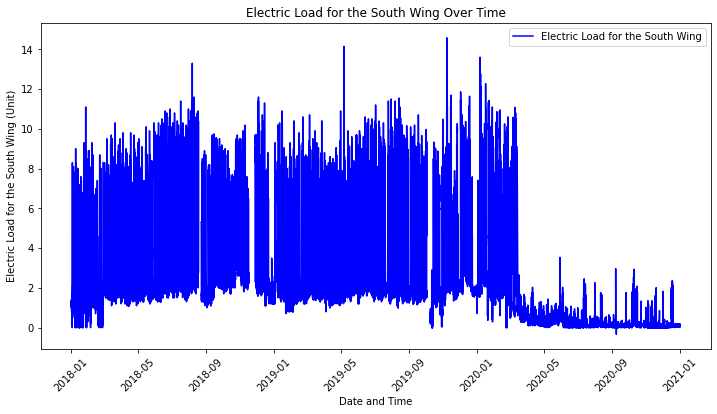

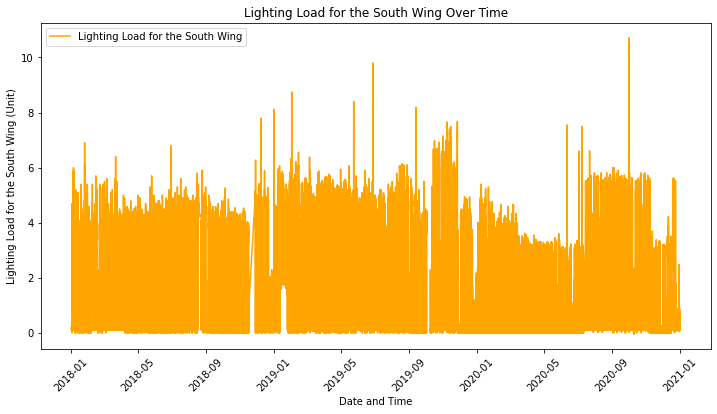

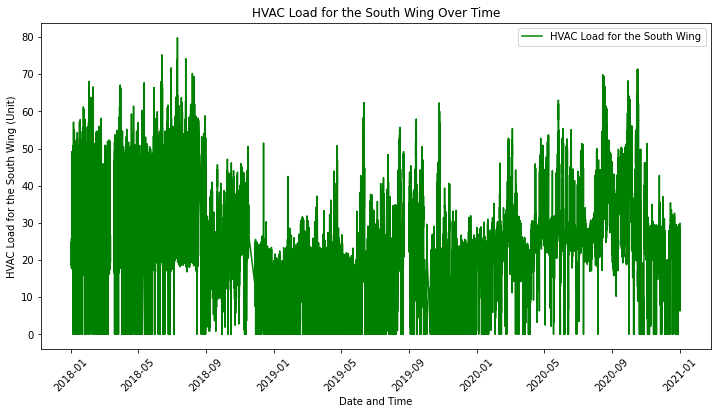

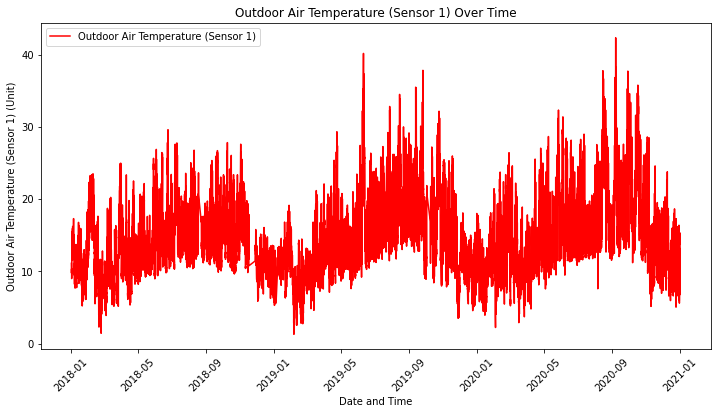

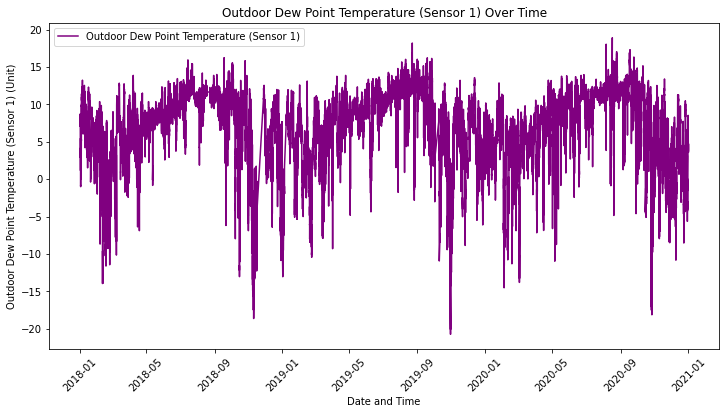

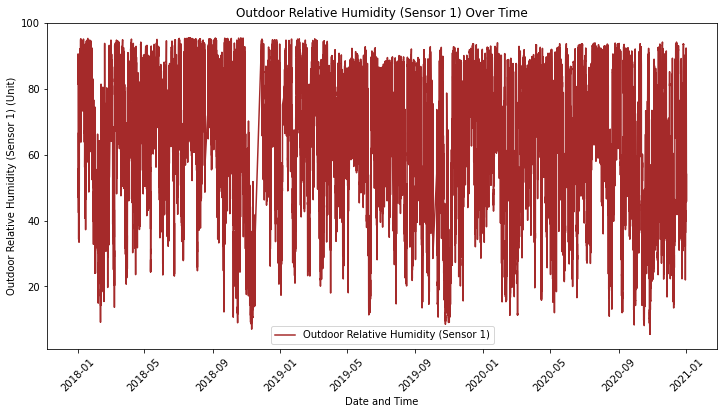

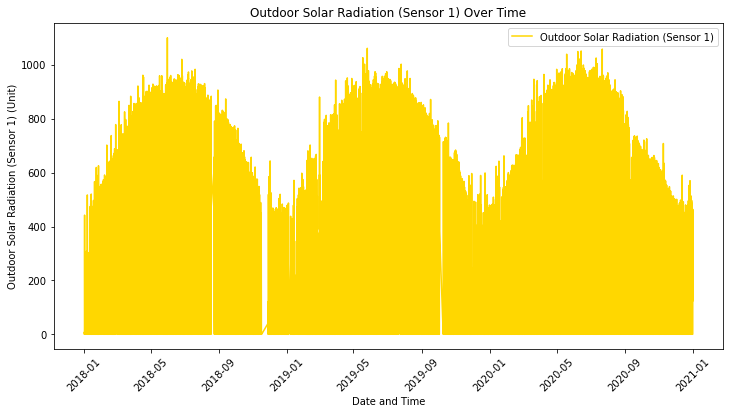

In [68]:
def plot_variable(variable, label, color):
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['date'], merged_data[variable], label=label, color=color)
    plt.title(f'{label} Over Time')
    plt.xlabel('Date and Time')
    plt.ylabel(f'{label} (Unit)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# List of variables, labels, and colors
variables = ['mels_S', 'lig_S', 'hvac_S', 'air_temp_set_1', 'dew_point_temperature_set_1d', 'relative_humidity_set_1', 'solar_radiation_set_1']
labels = ['Electric Load for the South Wing', 'Lighting Load for the South Wing', 'HVAC Load for the South Wing',
          'Outdoor Air Temperature (Sensor 1)', 'Outdoor Dew Point Temperature (Sensor 1)', 'Outdoor Relative Humidity (Sensor 1)', 'Outdoor Solar Radiation (Sensor 1)']
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'gold']

# Plot each variable in the list
for variable, label, color in zip(variables, labels, colors):
    plot_variable(variable, label, color)

The data ranges from 2018 to 2020. We see the overall electric energy consumption in this building drop in 2020 due to the pandemic. However, the HVAC system was contiuous and required to work at full capacity to keep air flow throughout the building. We will use the HVAC energy consumption as are target variable.

In [52]:
merged_data['date'] = pd.to_datetime(merged_data['date'])
merged_data.set_index('date', inplace=True)  

# Resample to hourly intervals
merged_data = merged_data.resample('H').mean()

In [29]:
energy_df = merged_data[['hvac_S']]

<Figure size 1008x576 with 0 Axes>

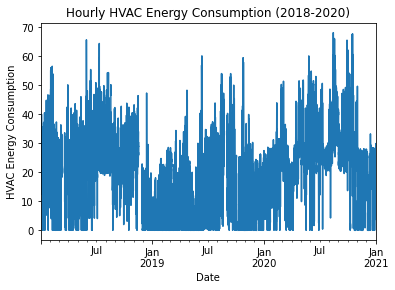

In [31]:
# Plot the data
plt.figure(figsize=(14, 8))
energy_df.plot(y='hvac_S', legend=False)  
plt.xlabel('Date')
plt.ylabel('HVAC Energy Consumption')
plt.title('Hourly HVAC Energy Consumption (2018-2020)')

# Show the plot
plt.show()

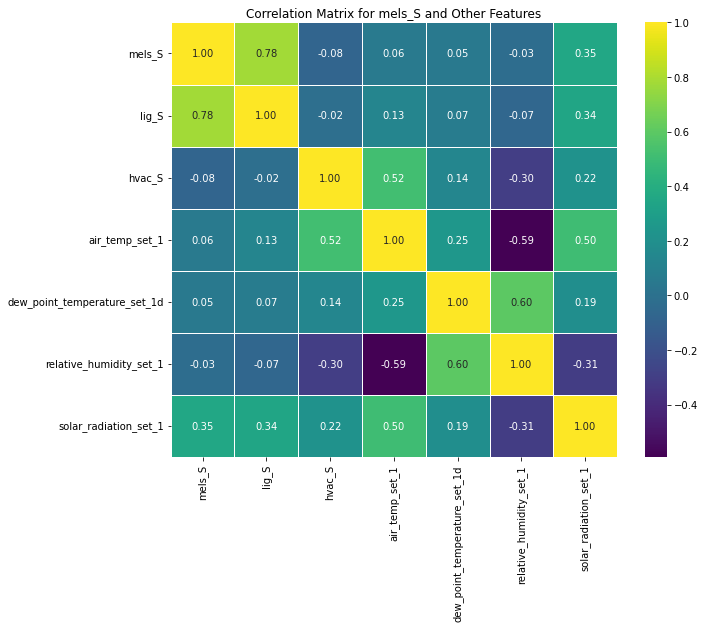

In [55]:
# Select relevant columns for correlation analysis
correlation_columns_S = ['mels_S','lig_S','hvac_S','air_temp_set_1','dew_point_temperature_set_1d',
                         'relative_humidity_set_1','solar_radiation_set_1']

# Create a subset of the DataFrame with selected columns
subset_S = merged_data[correlation_columns_S]

# Calculate correlation matrix
correlation_matrix_S = subset_S.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_S, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for mels_S and Other Features')
plt.show()

### Combine Datasets

In [57]:
# Find the start and end dates for this dataset to be able to combine with weather data
date_range_start = merged_data['date'].min()
date_range_end = merged_data['date'].max()

print("Date Range for the Merged Data:")
print("Start Date:", date_range_start)
print("End Date:", date_range_end)

Date Range for the Merged Data:
Start Date: 2018-01-01 01:00:00
End Date: 2021-01-01 00:00:00


In [58]:
# Extract the hour from the 'date' column
merged_data['hour'] = merged_data['date'].dt.hour

# Keep only the rows where the minute part is 00
hour_data = merged_data[merged_data['date'].dt.minute == 0].copy()

# Drop the 'hour' column as it's no longer needed
hour_data.drop('hour', axis=1, inplace=True)

# Reset the index for df2
hour_data.reset_index(drop=True, inplace=True)

# Display the first few rows of df2
print("First few rows of data at hourly intervals:")
print(hour_data.shape)
# display(hour_data.head())

First few rows of data at hourly intervals:
(25383, 11)


,date,mels_S,lig_S,mels_N,hvac_N,hvac_S,air_temp_set_1,air_temp_set_2,dew_point_temperature_set_1d,relative_humidity_set_1,solar_radiation_set_1
0,2018-01-01 01:00:00,1.20,0.20,7.50,37.40,19.50,11.12,11.15,8.04,81.50,6.45
1,2018-01-01 02:00:00,1.10,0.20,7.30,37.40,24.70,10.79,10.84,8.01,83.10,0.00
2,2018-01-01 03:00:00,1.10,0.20,6.90,37.40,18.70,10.56,10.62,8.03,84.50,0.00
3,2018-01-01 04:00:00,1.40,0.20,7.20,37.20,23.30,10.17,10.27,7.98,86.40,0.00
4,2018-01-01 05:00:00,1.20,0.20,6.95,36.20,18.60,9.83,9.94,8.10,89.10,0.00


In [62]:
# Reset the index for df_hour_subset
df_hour_subset.reset_index(inplace=True)

# Now, you can merge df_hour_subset with merged_data
merged_data_hourly = pd.merge(df_hour_subset, hour_data, left_on='dt_iso', right_on='date', how='inner')

In [64]:
merged_data_hourly.drop(columns=['lig_S', 'dt_iso', 'temp_min', 'temp_max', 'feels_like',
       'mels_N', 'hvac_N', 'air_temp_set_1', 'air_temp_set_2',
       'dew_point_temperature_set_1d', 'relative_humidity_set_1',
       'solar_radiation_set_1', 'mels_S', #'hvac_S',
                                ],inplace=True)

In [65]:
merged_data_hourly.to_csv(data_path + 'Weather_and_Energy_dataset.csv',index=False)

### Correlation

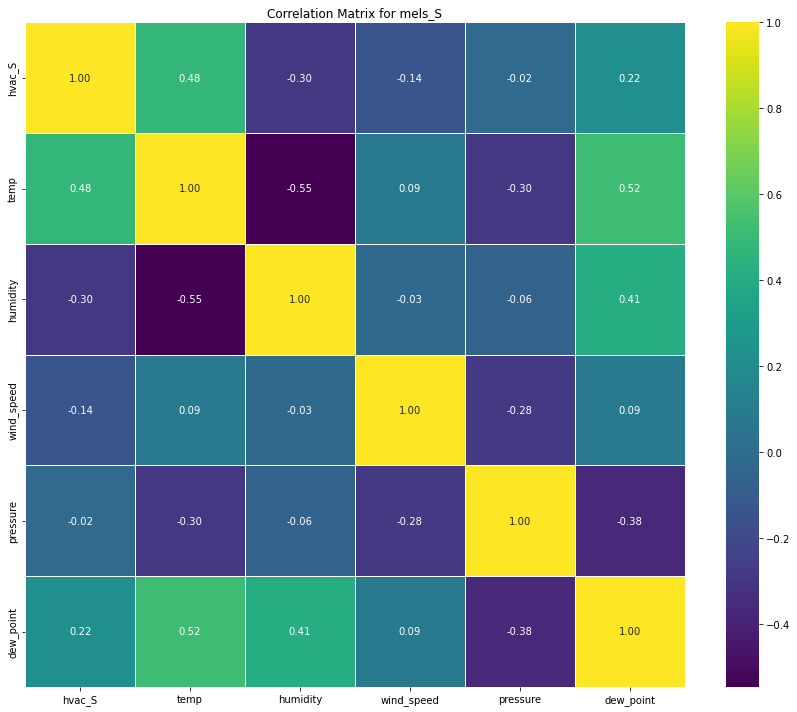

In [67]:
# Select relevant columns for correlation analysis
correlation_cols = ['hvac_S', 'temp', 'humidity', 'wind_speed',
                    'pressure', 'dew_point', 'date', ]

# Create a DataFrame with the selected columns
correlation_data = merged_data_hourly[correlation_cols]

# Calculate the correlation matrix
correlation_matrix_S = correlation_data.corr()

plt.figure(figsize=(12, 10))

# Plot for mels_S
plt.subplot(1, 1, 1)
sns.heatmap(correlation_matrix_S, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for mels_S')

plt.tight_layout()
plt.show()

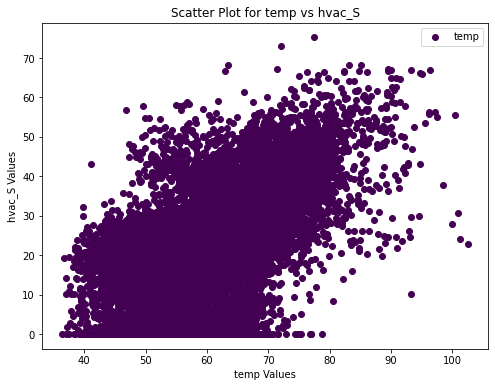

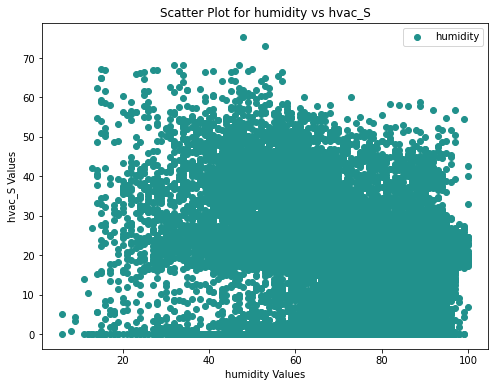

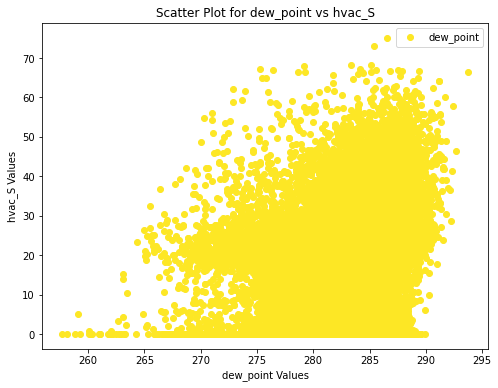

In [68]:
# Identify the top 3 correlated variables with 'hvac_S'
top_correlations_S = correlation_matrix_S['hvac_S'].abs().sort_values(ascending=False)[1:4]
top_variables_S = top_correlations_S.index

# Create separate scatter plots for each of the top 3 correlated variables with different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_variables_S)))

for variable, color in zip(top_variables_S, colors):
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_data_hourly[variable], merged_data_hourly['hvac_S'], color=color, label=variable)
    plt.title(f'Scatter Plot for {variable} vs hvac_S')
    plt.xlabel(f'{variable} Values')
    plt.ylabel('hvac_S Values')
    plt.legend()
    plt.show()